In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import time
from sklearn import datasets
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import mixture
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
import pyodbc
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kruskal
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor


## One Hot Encoding and Normalization

To prepare our input values for model testing, we must perform one hot encoding for all categorical variables. This means we reassign the input feature as a binary variable, where each category becomes a boolean of whether or not the category applies to that input. This will be performed on `Crop Group`, `FAO Crop Name`,`Country`, and `Iso3Code`.


In [2]:
# function to create Pandas dataframe from list of column tuples

# inputs: df (Pandas DataFrame), escape (columns that don't need to be normalized or one-hot encoded)
# output: normalized Pandas DataFrame

def norm_one_hot(df, escape=[]):
    data_list = list()
    for field in list(df.columns):
        if field in escape:
            field_df = df[field]
        elif df[field].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            if df[field].std() == 0:
                field_df = df[field] * 0
            else:
                field_df = (df[field] - df[field].mean()) / df[field].std() # normalize column
        else:
            field_df = pd.get_dummies(df[field], drop_first=True) # one-hot embedding

        data_list.append(field_df)

    # concatenate dataframes
    df_normalized = pd.concat(data_list, axis=1)

    return df_normalized

# Data Imputation Approach 1 - Row Deletition of Missing Data Cells:

The original length of our current dataset for modeling contains ~ 40,000 entries. However, due to the limitation of some input features such as `Production Quantity` and `Import/Export Value`, for incomplete entries, we resort to row deleton to preserve every full-lenght feature, which results to ~ 7,000 entries.

In [8]:
output = pd.read_csv('../Output_Data/tariff_model_data.csv')
output = output[(output['democracy level'] > 0) & (output['gdp per capita'] > 0) & (output['import trade value'] > 0) & (output['production quantity']> 0) & (output['FAO Cropname'] != ' ') & (output['export trade value'] > 0)]
#result = output.sample(n=100, replace =False)
output.to_csv('../Output_Data/tariff_model_data_FILTERED.csv')


"\n    output = pd.read_csv('../Output_Data/tariff_model_data.csv')\n    output = output[(output['democracy level'] > 0) & (output['gdp per capita'] > 0) & (output['import trade value'] > 0) & (output['production quantity']> 0) & (output['FAO Cropname'] != ' ') & (output['export trade value'] > 0)]\n    #result = output.sample(n=100, replace =False)\n    output.to_csv('../Output_Data/tariff_model_data_FILTERED.csv')\n"

In [3]:
df=pd.read_csv('tariff_model_data_FILTERED.csv') 

In [4]:
X = df.drop(['mfn','Crop ID', 'Unnamed: 0', 'Unnamed: 0.1'], axis = 1)   
X = norm_one_hot(X, ['production quantity','percent gdp from agriculture','import trade value','export trade value', 'gdp per capita','democracy level', 'edible', 'modified', 'fresh', 'frozen', 'shelled', 'dried', 'chilled', 'seed', 'ground', 'preserved'])
col_names = list(X.columns)

# Model 1: Random Forest Regression

We implemented a random forrest regressor model to predict the tariff rates of ~ 7000 data entries, splitting the training/testing data by 70-30% ratio, which 1000 averaged estimator decision trees.

In [5]:
Y = df['mfn']
start_time = time.time()
#polynomial_features= PolynomialFeatures(degree=3)
#X = polynomial_features.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute performance: {elapsed_time:.3f} seconds")

Elapsed time to compute performance: 31.705 seconds


The subsequent analysis reports the following metrics:

* `Correlation Coefficient`: The level of correlation between the input features and the output result, the tariff rate.
* `Mean Absolute Error`: The average distance between the predicted and actual output values.
* A side-by-side comparison of the actual and predicted mfn rates, as a numpy array.
* `Precision Accuracy`: The number of correctly predicted tariff rates, bound by `Margin of Error, MOE`, which is the number of percentage points a predicted value is allowed to be away from the actual value to be considered a "correct prediction". 

In [6]:
print('Correlation Coefficient:', model.score(X_test, Y_test))

#mean squared error
print('Mean abolute error in predictions:', metrics.mean_absolute_error(Y_test, Y_pred))

actual = list(Y_test)
predicted = list(Y_pred)

#importances = model.feature_importances_
#print('Feature Importance List: ', importances) 

print('Actual results:', np.array(Y_test))
print('Model-Generated Results:', np.array(Y_pred))

#Check the accuracy of the model, usng adjusted maringal error of 1-5%

moe = 4

num_accurate = 0
num_inaccurate = 0
for index, element in enumerate(actual):
    if abs(element - predicted[index]) < moe:
        num_accurate += 1
    else:
        num_inaccurate += 1

print('Accuracy Results: Found with a Margin of Error of 土' + str(moe) + '%. \n')
print('Number of predicted tariffs within ' + str(moe) + '% of actual:', num_accurate)
print('Number of predicted tariffs outside ' + str(moe) + '% of actual:', num_inaccurate)

print('Prediction Accuracy of Model:', round(num_accurate/(num_accurate+num_inaccurate),4))


Correlation Coefficient: 0.6836348518035504
Mean abolute error in predictions: 3.2381778109885766
Actual results: [12.80000019  0.          6.         ... 15.          9.19999981
  5.        ]
Model-Generated Results: [12.01282445  0.77766667  5.69907309 ... 19.7705487   9.08530201
  5.46449167]
Accuracy Results: Found with a Margin of Error of 土4%. 

Number of predicted tariffs within 4% of actual: 1413
Number of predicted tariffs outside 4% of actual: 430
Prediction Accuracy of Model: 0.7667


# Feature Importance

We then use the `feature_importances_` attribute of the model to plot the 12 most weighed features the model uses in its predictions. The resulting feature set can be categorized as follows:

* `Auxiliary Data` - data regarding the preparation of crops
* `Trade Data` - trade statistics of crop relating to importing country:
    - `Import/Export Value`
    - `Production Quantity`
* `Country-Level Data` - country-specific socioeconomic data:
    - `Democracy Level`
    - `% GDP from Agriculture`
    - `GDP Per Capita`

Text(0.5, 0, 'Random Forest Significant Feature Importance')

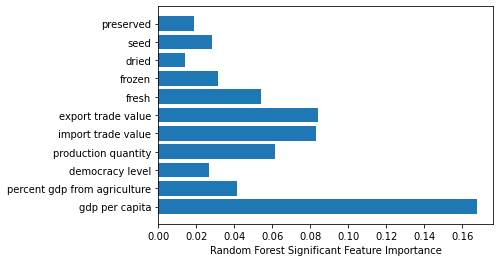

In [7]:
f_names = []
f_features = []
for index, val in enumerate(list(model.feature_importances_)):
    if val > 0.01:
        f_features.append(val)
        f_names.append(col_names[index])

plt.barh(f_names[7:], f_features[7:])
plt.xlabel("Random Forest Significant Feature Importance")